In [1]:
# ============================
# Task 3: Heart Disease Prediction
# ============================

# Core
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Modeling & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

# Utilities
import os

# Set a global random seed for reproducibility
RANDOM_STATE = 42

# Make plots a bit prettier
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

print("Imports ready.")


Imports ready.


In [6]:
# ===========================================
# Load dataset (upload if not present)
# ===========================================

# Expected Kaggle file name (commonly 'heart.csv' for the UCI Heart Disease dataset)
DEFAULT_FILENAME = "Heart.csv"

def load_or_upload_csv(filename=DEFAULT_FILENAME):

    if os.path.exists(filename):
        print(f"Found '{filename}' in the working directory.")
        return pd.read_csv(filename)
    else:
        print(f"'{filename}' ")
        try:
            from google.colab import files  # Only available in Colab
            uploaded = files.upload()
            # Use the first uploaded file as dataframe
            up_name = list(uploaded.keys())[0]
            print(f"Uploaded: {up_name}")
            return pd.read_csv(up_name)
        except Exception as e:
            raise FileNotFoundError(
                "Could not find or upload the dataset. "
            ) from e

df = load_or_upload_csv()
print("Shape:", df.shape)
df.head()


'Heart.csv' 


Saving Heart.csv.csv to Heart.csv (1).csv
Uploaded: Heart.csv (1).csv
Shape: (1025, 14)


,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,rest_ecg,Max_heart_rate,exercise_induced_angina,oldpeak,slope,vessels_colored_by_flourosopy,thalassemia,target
0,52,Male,Typical angina,125,212,Lower than 120 mg/ml,ST-T wave abnormality,168,No,1.0,Downsloping,Two,Reversable Defect,0
1,53,Male,Typical angina,140,203,Greater than 120 mg/ml,Normal,155,Yes,3.1,Upsloping,Zero,Reversable Defect,0
2,70,Male,Typical angina,145,174,Lower than 120 mg/ml,ST-T wave abnormality,125,Yes,2.6,Upsloping,Zero,Reversable Defect,0
3,61,Male,Typical angina,148,203,Lower than 120 mg/ml,ST-T wave abnormality,161,No,0.0,Downsloping,One,Reversable Defect,0
4,62,Female,Typical angina,138,294,Greater than 120 mg/ml,ST-T wave abnormality,106,No,1.9,Flat,Three,Fixed Defect,0


In [7]:
# ==================================
# Basic info & clean-up
# ==================================
print("Columns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

# If your dataset uses different label names (e.g., 'target', 'Outcome'), set it here:
TARGET_COL = 'target'
if TARGET_COL not in df.columns:
    raise KeyError(
        f"'{TARGET_COL}' column not found. "

    )

# Drop duplicate rows if any (optional but safe)
before = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
after = df.shape[0]
print(f"\nDropped {before - after} duplicate rows (if any).")

# Ensure no missing values remain (UCI version typically has none; if any, we can impute)
# For simplicity here: drop rows with NA (or you can add imputation logic)
na_rows = df.isna().any(axis=1).sum()
if na_rows > 0:
    print(f"Found {na_rows} rows with missing values. Dropping them.")
    df = df.dropna().reset_index(drop=True)
else:
    print("No missing values found.")

df.sample(5)


Columns: ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholestoral', 'fasting_blood_sugar', 'rest_ecg', 'Max_heart_rate', 'exercise_induced_angina', 'oldpeak', 'slope', 'vessels_colored_by_flourosopy', 'thalassemia', 'target']

Data types:
 age                                int64
sex                               object
chest_pain_type                   object
resting_blood_pressure             int64
cholestoral                        int64
fasting_blood_sugar               object
rest_ecg                          object
Max_heart_rate                     int64
exercise_induced_angina           object
oldpeak                          float64
slope                             object
vessels_colored_by_flourosopy     object
thalassemia                       object
target                             int64
dtype: object

Missing values per column:
 age                              0
sex                              0
chest_pain_type                  0
resting_blood_pressure

,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,rest_ecg,Max_heart_rate,exercise_induced_angina,oldpeak,slope,vessels_colored_by_flourosopy,thalassemia,target
69,47,Male,Non-anginal pain,138,257,Lower than 120 mg/ml,Normal,156,No,0.0,Downsloping,Zero,Fixed Defect,1
210,56,Female,Atypical angina,140,294,Lower than 120 mg/ml,Normal,153,No,1.3,Flat,Zero,Fixed Defect,1
107,66,Male,Typical angina,120,302,Lower than 120 mg/ml,Normal,151,No,0.4,Flat,Zero,Fixed Defect,1
51,55,Male,Typical angina,140,217,Lower than 120 mg/ml,ST-T wave abnormality,111,Yes,5.6,Upsloping,Zero,Reversable Defect,0
86,76,Female,Non-anginal pain,140,197,Lower than 120 mg/ml,Left ventricular hypertrophy,116,No,1.1,Flat,Zero,Fixed Defect,1


,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,rest_ecg,Max_heart_rate,exercise_induced_angina,oldpeak,slope,vessels_colored_by_flourosopy,thalassemia,target
count,302.00000,302,302,302.000000,302.000000,302,302,302.000000,302,302.000000,302,302,302,302.000000
unique,NaN,2,4,NaN,NaN,2,3,NaN,2,NaN,3,5,4,NaN
top,NaN,Male,Typical angina,NaN,NaN,Lower than 120 mg/ml,ST-T wave abnormality,NaN,No,NaN,Downsloping,Zero,Fixed Defect,NaN
freq,NaN,206,143,NaN,NaN,257,151,NaN,203,NaN,141,175,165,NaN
mean,54.42053,NaN,NaN,131.602649,246.500000,NaN,NaN,149.569536,NaN,1.043046,NaN,NaN,NaN,0.543046
std,9.04797,NaN,NaN,17.563394,51.753489,NaN,NaN,22.903527,NaN,1.161452,NaN,NaN,NaN,0.498970
min,29.00000,NaN,NaN,94.000000,126.000000,NaN,NaN,71.000000,NaN,0.000000,NaN,NaN,NaN,0.000000
25%,48.00000,NaN,NaN,120.000000,211.000000,NaN,NaN,133.250000,NaN,0.000000,NaN,NaN,NaN,0.000000
50%,55.50000,NaN,NaN,130.000000,240.500000,NaN,NaN,152.500000,NaN,0.800000,NaN,NaN,NaN,1.000000
75%,61.00000,NaN,NaN,140.000000,274.750000,NaN,NaN,166.000000,NaN,1.600000,NaN,NaN,NaN,1.000000


Class distribution:
 target
0    138
1    164
Name: count, dtype: int64


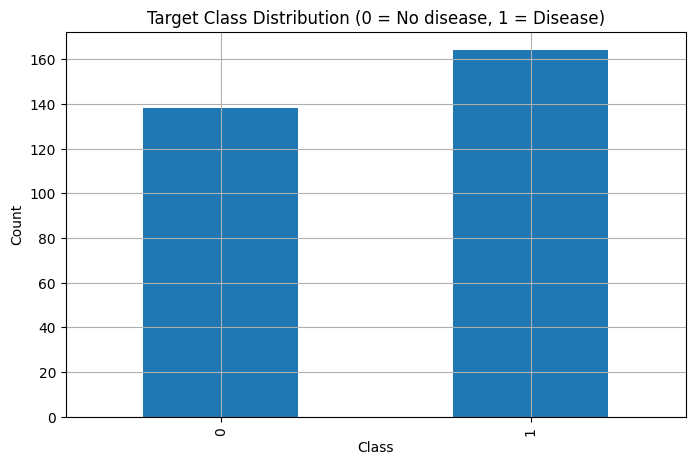


Top correlations with target:
 Max_heart_rate            0.419955
cholestoral              -0.081437
resting_blood_pressure   -0.146269
age                      -0.221476
oldpeak                  -0.429146
Name: target, dtype: float64


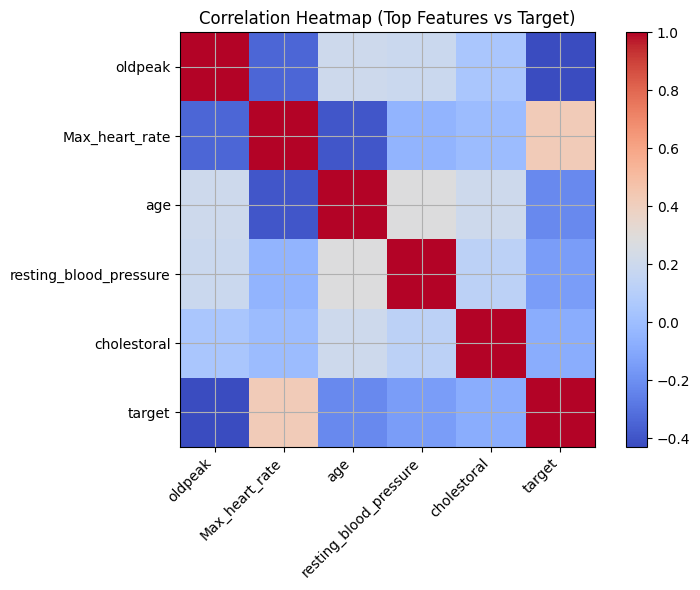

In [8]:
# =========================================
# EDA - distributions & correlation
# =========================================

# Quick summary stats
display(df.describe(include='all'))

# Class balance
class_counts = df[TARGET_COL].value_counts().sort_index()
print("Class distribution:\n", class_counts)

# Plot class balance
class_counts.plot(kind='bar')
plt.title("Target Class Distribution (0 = No disease, 1 = Disease)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Correlation (numerical only)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_cols].corr()

# Show top correlations with target
target_corr = corr[TARGET_COL].drop(TARGET_COL).sort_values(ascending=False)
print("\nTop correlations with target:\n", target_corr.head(10))

# Plot a small correlation heatmap (focusing on top 8 related to target to keep it readable)
top_features = target_corr.abs().sort_values(ascending=False).head(8).index.tolist()
to_plot = df[top_features + [TARGET_COL]].corr()

plt.figure(figsize=(8,6))
plt.imshow(to_plot, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(to_plot.columns)), to_plot.columns, rotation=45, ha='right')
plt.yticks(range(len(to_plot.index)), to_plot.index)
plt.title("Correlation Heatmap (Top Features vs Target)")
plt.tight_layout()
plt.show()


In [9]:
# =======================================================
# Define numeric & categorical feature columns
# =======================================================

# Many Kaggle UCI heart datasets treat these as numeric integers (even if categorical by nature).
# We'll treat some as categorical for better modeling with OneHotEncoder.
# Adjust if your CSV differs.

# Common columns in the UCI heart dataset:
# age (num), sex (bin), cp (cat), trestbps (num), chol (num), fbs (bin),
# restecg (cat), thalach (num), exang (bin), oldpeak (num),
# slope (cat), ca (cat), thal (cat), target (bin)

possible_categorical = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
categorical_cols = [c for c in possible_categorical if c in df.columns and c != TARGET_COL]

# Numeric columns are the numeric ones minus the target and any chosen categorical
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in categorical_cols + [TARGET_COL]]

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]


Numeric columns: ['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak']
Categorical columns: ['sex', 'slope']


In [10]:
# ============================================================
# ColumnTransformer + Train/Test split with stratify
# ============================================================

# Preprocess pipeline:
# - OneHotEncode categorical features (drop='first' to avoid multicollinearity)
# - StandardScale numeric features (Logistic Regression benefits from scaling)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ],
    remainder='drop'  # keep only specified columns
)

# Stratified split to keep class balance consistent across train & test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Class balance in Train:\n", y_train.value_counts(normalize=True).round(3))
print("Class balance in Test:\n", y_test.value_counts(normalize=True).round(3))


Train shape: (241, 13)  Test shape: (61, 13)
Class balance in Train:
 target
1    0.544
0    0.456
Name: proportion, dtype: float64
Class balance in Test:
 target
1    0.541
0    0.459
Name: proportion, dtype: float64


In [11]:
# ========================================
# Train Logistic Regression model
# ========================================

log_reg = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

log_reg.fit(X_train, y_train)

# Predictions & Probabilities
y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

# Metrics
acc_lr = accuracy_score(y_test, y_pred_lr)
roc_lr = roc_auc_score(y_test, y_proba_lr)

print(f"Logistic Regression - Accuracy: {acc_lr:.3f}, ROC-AUC: {roc_lr:.3f}")
print("\nClassification Report (Logistic Regression):\n")
print(classification_report(y_test, y_pred_lr, digits=3))


Logistic Regression - Accuracy: 0.770, ROC-AUC: 0.866

Classification Report (Logistic Regression):

              precision    recall  f1-score   support

           0      0.706     0.857     0.774        28
           1      0.852     0.697     0.767        33

    accuracy                          0.770        61
   macro avg      0.779     0.777     0.770        61
weighted avg      0.785     0.770     0.770        61



In [12]:
# ==============================
# Train Decision Tree
# ==============================

tree = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', DecisionTreeClassifier(
        max_depth=4, random_state=RANDOM_STATE
    ))
])

tree.fit(X_train, y_train)

# Predictions & Probabilities
y_pred_tree = tree.predict(X_test)
# For ROC-AUC we need probabilities; DecisionTreeClassifier has predict_proba
y_proba_tree = tree.predict_proba(X_test)[:, 1]

# Metrics
acc_tree = accuracy_score(y_test, y_pred_tree)
roc_tree = roc_auc_score(y_test, y_proba_tree)

print(f"Decision Tree     - Accuracy: {acc_tree:.3f}, ROC-AUC: {roc_tree:.3f}")
print("\nClassification Report (Decision Tree):\n")
print(classification_report(y_test, y_pred_tree, digits=3))


Decision Tree     - Accuracy: 0.705, ROC-AUC: 0.669

Classification Report (Decision Tree):

              precision    recall  f1-score   support

           0      0.667     0.714     0.690        28
           1      0.742     0.697     0.719        33

    accuracy                          0.705        61
   macro avg      0.704     0.706     0.704        61
weighted avg      0.707     0.705     0.705        61



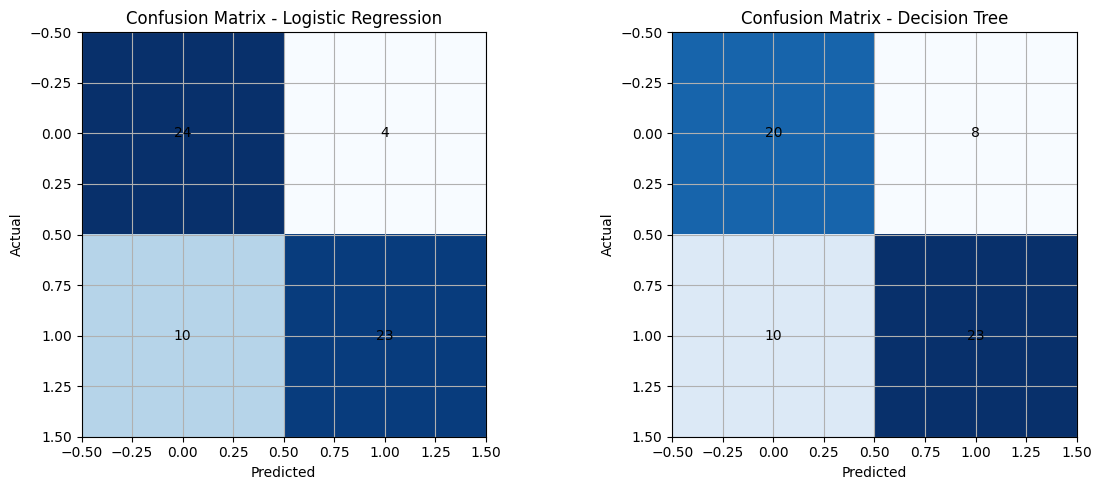

In [13]:
# =========================================
# Confusion matrices (side by side)
# =========================================

cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_tree = confusion_matrix(y_test, y_pred_tree)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Logistic Regression CM
axes[0].imshow(cm_lr, cmap='Blues')
axes[0].set_title("Confusion Matrix - Logistic Regression")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
for (i, j), val in np.ndenumerate(cm_lr):
    axes[0].text(j, i, int(val), ha='center', va='center')

# Decision Tree CM
axes[1].imshow(cm_tree, cmap='Blues')
axes[1].set_title("Confusion Matrix - Decision Tree")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
for (i, j), val in np.ndenumerate(cm_tree):
    axes[1].text(j, i, int(val), ha='center', va='center')

plt.tight_layout()
plt.show()


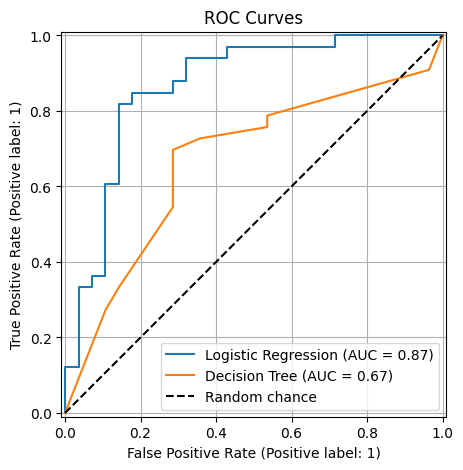

In [14]:
# ================================
# ROC curves comparison
# ================================

fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, y_proba_lr, name="Logistic Regression", ax=ax)
RocCurveDisplay.from_predictions(y_test, y_proba_tree, name="Decision Tree", ax=ax)
ax.plot([0, 1], [0, 1], 'k--', label='Random chance')
ax.set_title("ROC Curves")
ax.legend()
plt.show()


In [17]:
# ========================================
# Quick model comparison summary
# ========================================
summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_tree)],
    'ROC_AUC': [roc_auc_score(y_test, y_proba_lr), roc_auc_score(y_test, y_proba_tree)]
}).sort_values('ROC_AUC', ascending=False).reset_index(drop=True)

print("Model Comparison (higher is better):")
display(summary.style.format({'Accuracy': '{:.3f}', 'ROC_AUC': '{:.3f}'}))


Model Comparison (higher is better):


,Model,Accuracy,ROC_AUC
0,Logistic Regression,0.770,0.866
1,Decision Tree,0.705,0.669
